<a href="https://colab.research.google.com/github/yanxiliu37/CITS4012_Labs/blob/main/CITS4012_Lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab03

## Neural Network Example
We are going to implement a Neural Network for identifying animal species using features of animals.

In [ ]:
import torch
import numpy as np

Let's say we have two features that represent the following two aspects:
1. Does the animal have hair?
2. Does the animal have feathers?



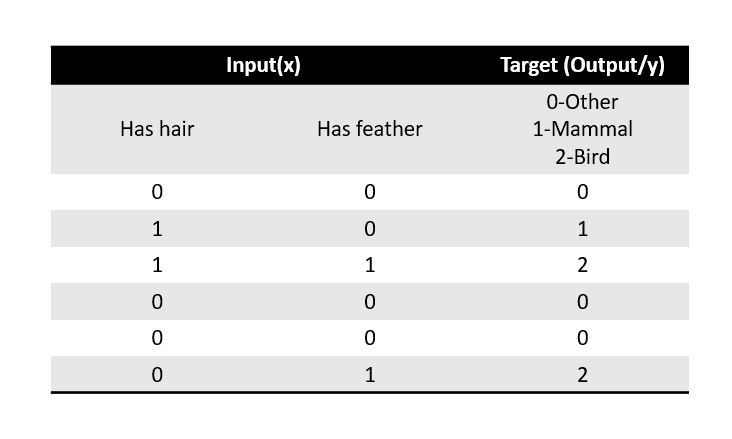

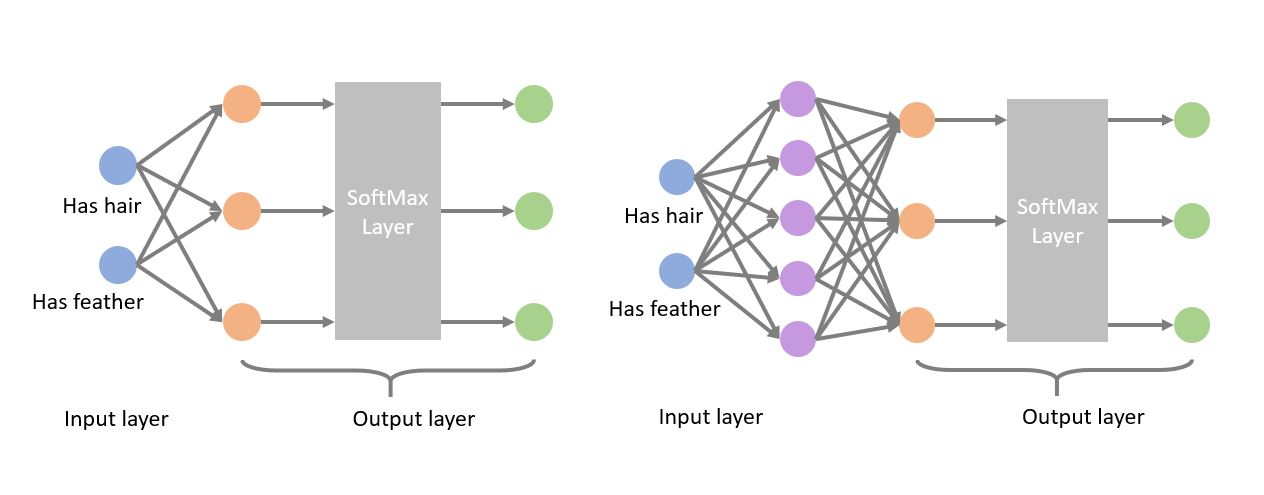

We would like to predict whether the animal is a bird, a mammal, or something else.

In [ ]:
# Create our feature data
# [Hair, Feather]: 0 means doesn't have, 1 means have
# e.g. [1, 0] indicates the animal has hair and doesn't have feathers
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# We need to transform the data into a Torch data type to be used in Pytorch
x_data_torch = torch.from_numpy(x_data).float()
# Uncomment the following line if you want to see the details
# print(x_data_torch)

# Create our target data
y_data = np.array([0,1,2,0,0,2]) # 0-Other  1-Mammal  2-Bird
y_data_torch = torch.from_numpy(y_data)
# Uncomment the following line if you want to see the details
# print(y_data_torch)

# number of inputs (features), 2 - Hair, Feather
num_features = 2
# number of output (classes), 3 - Other, Mammal, Bird
num_classes = 3

### No hidden layer with Manual Parameter Update

Build a classification model without a hidden layer.
We manually update the parameters (weight and bias) in this example.

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Initialize Weight and Bias manually, and setup the gradient
# torch.randn returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution)
W1 = torch.randn(num_features, num_classes, requires_grad=True)
B1 = torch.randn(num_classes, requires_grad=True)

# Learning Rate - determines the step size at each iteration while moving toward a minimum of a loss function
learning_rate=0.01

# Epoch - A measure of the number of times all of the training vectors are used once to update the weights.
number_of_epochs = 1000 # TODO: try 2000 epochs and see how it goes

for epoch in range(number_of_epochs):

    # forward propagataion - the calculation and storage of intermediate variables (incl. outputs) from the input layer to the output layer
    z = torch.add(torch.matmul(x_data_torch, W1), B1)

    # softmax changes each value to be between 0 and 1, and all values will add up to 1. Can you see this is like a probability distribution?
    # i.e. [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
    # log_softmax applies logarithm after softmax.
    # softmax: exp(x_i) / exp(x).sum() and log_softmax: log( exp(x_i) / exp(x).sum() )
    # log_softmax essentially does log(softmax(x)), but the practical implementation is different and more efficient
    # https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax
    log_softmax = F.log_softmax(z, dim=1)

    # calculate the negative log likelihood loss
    loss = F.nll_loss(log_softmax, y_data_torch)

    # back propagation
    loss.backward()  #calculate gradient
    with torch.no_grad(): # When doing back propagation, do not accumulate gradient
        W1.data -= learning_rate*W1.grad.data #Gradient descent
        B1.data -= learning_rate*B1.grad.data
    W1.grad.data.zero_() # reset the gradient
    B1.grad.data.zero_()

    if epoch % 200 == 199:
        with torch.no_grad(): # prediction section does not require gradient
            pred_outputs = torch.add(torch.matmul(x_data_torch, W1), B1)
            predicted = torch.argmax(pred_outputs, 1)
            train_acc = accuracy_score(predicted.numpy(), y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))

# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 1.3283, train_acc: 0.167
Epoch: 400, loss: 1.0125, train_acc: 0.333
Epoch: 600, loss: 0.8297, train_acc: 0.833
Epoch: 800, loss: 0.7023, train_acc: 0.833
Epoch: 1000, loss: 0.6051, train_acc: 0.833
Predicted : [0 0 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 0.83


### No hidden layer with the Optimiser


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Build a neural network model rather than initializing the parameters manually
# torch.nn.Linear applies a linear transformation to the input data: y = Ax + b
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class ModelWithoutHiddenLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ModelWithoutHiddenLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size) # This corresponds to W1,B1

    def forward(self, x):
        x = self.linear(x)
        return x

# Initialize the model
model = ModelWithoutHiddenLayer(num_features, num_classes)

# learning rate
learning_rate=0.01

# calculate negative log likelihood loss
criterion = nn.NLLLoss()

# Define the optimiser
# Pass the model parameters to be updated, and set up the learning rate when calling optim.SGD
# Please find detailed information about the SGD optimiser in PyTorch (https://pytorch.org/docs/stable/optim.html).
optimiser = optim.SGD(model.parameters(), lr = learning_rate)

# For every epoch, the model weights will be modified using the given learning rate
no_of_epochs = 1000

for epoch in range(no_of_epochs):

    # get the inputs and labels
    inputs = x_data_torch
    labels = y_data_torch

    # set the module in training mode (for illustration)
    # A module can be set to training mode (net.train(mode=True)) or evaluation mode (when net.train(mode=False) or net.eval())
    # This has an effect only on certain modules such as Dropout, BatchNorm etc.
    model.train() # mode = True by default

    # set the gradients to zero
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(F.log_softmax(outputs,dim=1), labels)
    loss.backward()
    optimiser.step() # back propagation

    if epoch % 200 == 199:    # print every 200 epochs
        model.eval() # we are using the model to predict here, i.e. set the module to evaluation mode
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.3f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

# Result
model.eval()
pred_outputs = model(inputs)
predicted = torch.argmax(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.742, train_acc: 0.833
400, loss: 0.625, train_acc: 0.833
600, loss: 0.538, train_acc: 1.000
800, loss: 0.470, train_acc: 1.000
1000, loss: 0.415, train_acc: 1.000
Finished Training
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with Manual Parameter Update

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# you can find the detailed comments and explanation in the section - no hidden layer with manual parameter update section

# number of neurons in hidden layer,
n_hidden_1 = 5

# [Input(Features), Output(number of neurons in hidden layer)]
W1 = torch.randn(num_features, n_hidden_1, requires_grad=True)

# Let Hidden Layer Bias dimension be the number of output candidates, which is 5 (number of neurons in hidden layer).
B1 = torch.randn(n_hidden_1, requires_grad=True)

# [Input(number of neurons in hidden layer), Output(Classes)]
Wout = torch.randn(n_hidden_1, num_classes, requires_grad=True)

# Let Bias have dimension equal to the number of output candidates, which is 3 (number of classes).
Bout = torch.randn(num_classes, requires_grad=True)

learning_rate=0.01
no_of_epochs = 1000

for epoch in range(no_of_epochs):
    z1 = torch.add(torch.matmul(x_data_torch, W1), B1)
    Zout = torch.add(torch.matmul(F.relu(z1), Wout), Bout)

    log_softmax = F.log_softmax(Zout,dim=1)
    loss = F.nll_loss(log_softmax, y_data_torch)

    loss.backward()
    with torch.no_grad():
        W1.data -= learning_rate*W1.grad.data
        B1.data -= learning_rate*B1.grad.data
        Wout.data -= learning_rate*Wout.grad.data
        Bout.data -= learning_rate*Bout.grad.data

    W1.grad.data.zero_()
    B1.grad.data.zero_()
    Wout.grad.data.zero_()
    Bout.grad.data.zero_()

    if epoch % 200 == 199:
        with torch.no_grad():
            z1 = torch.add(torch.matmul(x_data_torch ,W1),B1)
            Zout = torch.add(torch.matmul(F.relu(z1) ,Wout),Bout)
            predicted = torch.argmax(Zout, 1)
            train_acc = accuracy_score(predicted.numpy(),y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item() , train_acc))
print("Finished")
# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.6545, train_acc: 0.833
Epoch: 400, loss: 0.4283, train_acc: 0.833
Epoch: 600, loss: 0.2734, train_acc: 1.000
Epoch: 800, loss: 0.1776, train_acc: 1.000
Epoch: 1000, loss: 0.1257, train_acc: 1.000
Finished
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with the Optimiser


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#you can find detailed comments and explanation in the section - no hidden layer with the optimiser section

class ModelWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModelWithHiddenLayer, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        z1 = self.linear1(x)
        Zout = self.linear2(F.relu(z1))
        return Zout

model = ModelWithHiddenLayer(num_features, n_hidden_1, num_classes)

learning_rate = 0.01
no_of_epochs = 1000

# If you apply Pytorch’s CrossEntropyLoss to your output layer,
# you get the same result as applying Pytorch’s NLLLoss to a LogSoftmax layer added after your original output layer.
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=learning_rate)

from sklearn.metrics import accuracy_score

for epoch in range(no_of_epochs):  # loop over the dataset multiple times

    # get the inputs
    inputs = x_data_torch
    labels = y_data_torch

    model.train()
    # zero the parameter gradients
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels) # We don't need to calculate logsoftmax here
    loss.backward()
    optimiser.step()

    # print statistics
    if epoch % 200 == 199:    # print every 200 epochs
        model.eval()
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.4f, train_acc: %.4f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

# Result
pred_outputs = model(inputs)
_, predicted = torch.max(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.8996, train_acc: 0.8333
400, loss: 0.7347, train_acc: 0.8333
600, loss: 0.5774, train_acc: 0.8333
800, loss: 0.4445, train_acc: 1.0000
1000, loss: 0.3405, train_acc: 1.0000
Finished Training
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


## Word2Vec on Pytorch
Let's try to implement Word2Vec - Skip Gram with a Neural Network via Pytorch

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Raw data - sentences
# Let's create some toy data for simplicity
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# extract the unique word list from the sentences
word_list = " ".join(sentences).split()
word_list = list(set(word_list))

# make a dictionary so that we can reference the index of each unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# make window size = 1 for skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]]]

        # skipgrams - (centre, context[0]), (centre, context[1])..
        for w in context:
            skip_grams.append([centre, w])

In [6]:
print (skip_grams)

[[3, 5], [5, 3], [5, 8], [8, 5], [3, 5], [5, 3], [5, 2], [2, 5], [3, 5], [5, 3], [5, 6], [6, 5], [2, 8], [8, 2], [8, 6], [6, 8], [9, 5], [5, 9], [5, 8], [8, 5], [9, 10], [10, 9], [10, 2], [2, 10], [8, 5], [5, 8], [5, 4], [4, 5], [8, 5], [5, 8], [5, 7], [7, 5], [2, 5], [5, 2], [5, 12], [12, 5], [2, 10], [10, 2], [10, 4], [4, 10], [2, 5], [5, 2], [5, 7], [7, 5], [9, 5], [5, 9], [5, 1], [1, 5], [9, 5], [5, 9], [5, 11], [11, 5], [3, 5], [5, 3], [5, 0], [0, 5], [3, 5], [5, 3], [5, 1], [1, 5], [8, 10], [10, 8], [10, 2], [2, 10]]


In [34]:
voc_size = len(word_list)

# prepare batch from skip-gram
def prepare_batch(data_temp):
    inputs = []
    labels = []

    for i in range(len(data_temp)):
        input_temp = [0]*voc_size
        input_temp[data_temp[i][0]] = 1 # ont-hot input
        inputs.append(input_temp)  # centre
        labels.append(data_temp[i][1])  # context word

    return np.array(inputs), np.array(labels)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from random import shuffle

batch_size = 16
learning_rate = 0.1
embedding_size = 2
no_of_epochs = 5000

# randomly initialise the weight vectors. Note there is no bias in word2vec
W1 = torch.randn(voc_size, embedding_size, requires_grad=True)
Wout = torch.randn(embedding_size, voc_size, requires_grad=True)

for epoch in range(no_of_epochs):

    # shuffle the training set to make each epoch's batch different, you can also skip this step
    shuffle(skip_grams)
    loss_sum = 0

    for ind in range(0,len(skip_grams),batch_size):
        data_temp = skip_grams[ind : min(ind+batch_size, len(skip_grams))]
        inputs_temp, labels_temp = prepare_batch(data_temp)

        inputs_torch = torch.from_numpy(inputs_temp).float()
        labels_torch = torch.from_numpy(labels_temp)

        hidden = torch.matmul(inputs_torch ,W1)
        out = torch.matmul(hidden,Wout)

        log_softmax = F.log_softmax(out, dim=1)
        loss = F.nll_loss(log_softmax, labels_torch)

        loss.backward()
        with torch.no_grad():
            W1.data -= learning_rate * W1.grad.data
            Wout.data -= learning_rate * Wout.grad.data
        W1.grad.data.zero_()
        Wout.grad.data.zero_()

        loss_sum += loss.item()

    if epoch % 500 == 499:
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))


Epoch: 500, loss: 5.6250
Epoch: 1000, loss: 5.5453
Epoch: 1500, loss: 5.5266
Epoch: 2000, loss: 5.4970
Epoch: 2500, loss: 5.4703
Epoch: 3000, loss: 5.4916
Epoch: 3500, loss: 5.4963
Epoch: 4000, loss: 5.4739
Epoch: 4500, loss: 5.4732
Epoch: 5000, loss: 5.4992


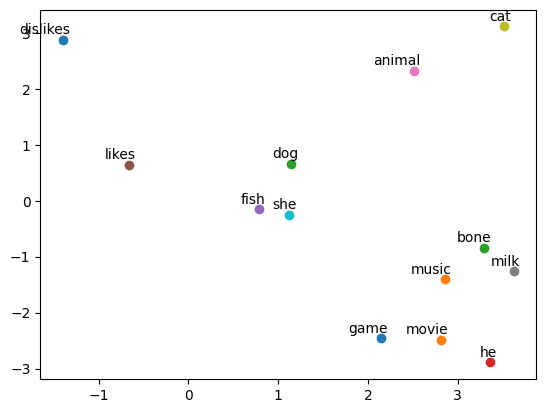

In [37]:
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

# Lab 3 Exercise
Please complete the following **question E1 and E2** for Lab 3 and check with your Lab Facilitator in the lab.


##E1. CBOW implementation with PyTorch nn.Module and torch.optim

In the lab, we learned how to train a word2vec skip-gram model in pytorch with manually updates the parameters (weights).


In this Lab 03 E1, please:

1.   use the "NN Model (**nn.Module**)" and the "Optimiser (**torch.optim**)" (that we learned in the above sections) to train a word2vec **CBOW (NOT Skip Gram)** model  on the provided toy data with **widow_size=1 and embedding_size=2**.




Note: The embedding size should be 2. The code for the preprocessing and the hyperparmeter setup are provided. Have fun!


In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from random import shuffle

# Raw data - sentences
# Let's create toy data for simplicity
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# convert all sentences to unique word list
word_list = " ".join(sentences).split()
word_list = list(set(word_list))


# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# make window size=1 for cbow
# i.e.) he likes cat
#   -> ([likes], he), ([he, cat], likes), ([likes], cat)
#   -> ([likes, likes], he), ([he, cat], likes), ([likes, likes], cat)
# Double the input when the word doesn't have two neighbours
# This will make your input have the same size, which will make it easier when you write the CBOW model code
# But this trick only works when window_size = 1

cbow = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]], word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i - 1]]]

        cbow.append([context, centre])


# hyperparameter
voc_size = len(word_list)
learning_rate = 0.1
batch_size = 16
embedding_size = 2
no_of_epochs = 5000

In [21]:
# prepare batch from cbow
def prepare_batch(data_temp):
    inputs = []
    labels = []

    for i in range(len(data_temp)):
        # ont-hot input - context
        input_temp = []
        for cw in data_temp[i][0]:
          cw_onehot=[0]*voc_size
          cw_onehot[cw]=1
          input_temp.append(cw_onehot)
        inputs.append(input_temp)

        # centre
        labels.append(data_temp[i][1])

    return np.array(inputs), np.array(labels)

### Your Solution

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class CBOW(nn.Module):
    def __init__(self,voc_size, embedding_size):
        super(CBOW, self).__init__()
        # You can fill in the code here
        self.linear1 = nn.Linear(voc_size, embedding_size)
        self.linear2 = nn.Linear(embedding_size, voc_size)

    def forward(self, x):
        # You can fill in the code here
        # Note: CBOW takes the average over all the projected vectors in the projection layer.
        z1 = self.linear1(x)
        # CBOW 是所有向量的平均值
        z1 = torch.mean(z1, dim=1)
        Zout = self.linear2(z1)

        return Zout


# Please complete the code to train the Pytorch CBOW model
# You are free to create and use multiple code cells based on your needs.
# You can refer to the sample code in the above section.





In [25]:
# 初始化模型，optimiser,损失函数
model= CBOW(voc_size, embedding_size)
optimiser = optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 训练数据
for epoch in range(no_of_epochs):
  shuffle(cbow)
  loss_sum = 0

  for ind in range(0,len(cbow),batch_size):
    data_temp = cbow[ind:min(ind+batch_size,len(cbow))] # 每次取 batch size大小的样本
    inputs_temp,labels_temp = prepare_batch(data_temp) # 转换为one-hot代码


    inputs_torch = torch.from_numpy(inputs_temp).float() # 转换问torch数据格式准备进行训练
    labels_torch = torch.from_numpy(labels_temp)

    model.train()
    optimiser.zero_grad()

    # 前向传播
    outputs = model(inputs_torch)
    loss = criterion(outputs,labels_torch)

    # 反向传播
    loss.backward()
    optimiser.step()


  # 打印loss
  if epoch % 500 == 499:
    print('Epoch: %d, loss: %.4f' %(epoch + 1, loss.item()))

Epoch: 500, loss: 1.1359
Epoch: 1000, loss: 1.5754
Epoch: 1500, loss: 1.1796
Epoch: 2000, loss: 0.9552
Epoch: 2500, loss: 1.2286
Epoch: 3000, loss: 1.2263
Epoch: 3500, loss: 0.8882
Epoch: 4000, loss: 1.4308
Epoch: 4500, loss: 1.1766
Epoch: 5000, loss: 1.6459


**Sample Output**
The sample output for model training log (only for format reference)



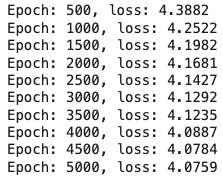

## E2. Word Embedding Extraction and Visualization

Based on the completion of E1, please visualize the derived word embedding for **CBOW Model above**.

### Your Solution

In [ ]:
# Extract and visualize the 2-dimensional word embeddings (i.e. from the trained projection layer matrix).
# You are free to create and use multiple code cells based on your needs
# You can also create subsections under the sections we provided based on your needs

# An example output can be found below (only for the embedding visualization format reference)

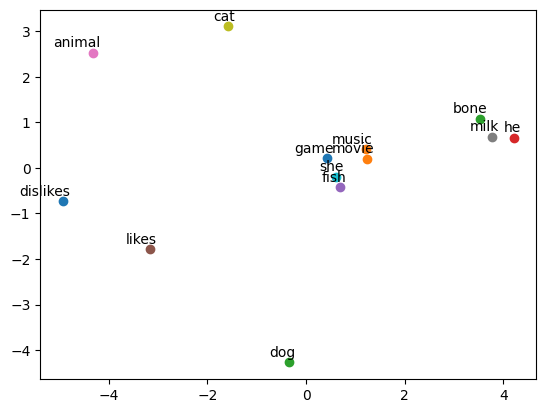

In [39]:
W1 = model.linear1.weight.data

# Get the trained projection matrix
trained_embeddings = W1.data.numpy()

# 如果是 (embedding_size, vocab_size)，要转置
if trained_embeddings.shape[0] != len(word_list):
    trained_embeddings = trained_embeddings.T

for i, label in enumerate(word_list):
    x, y = trained_embeddings[i, 0], trained_embeddings[i, 1]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()

**E2 Sample output**

The following is **the sample output (only for the embedding visualisation format reference) for E2**



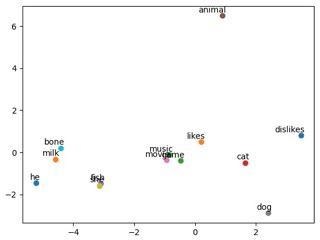